# XGBoost Decision Tree Classifier Assignment
## By: Patrick Liu 8)

# Some Background on The Dataset
- This dataset is pertained to mental health as well. In this case, an organization called OSMI (open sourcing mental illness), is a nonprofit organization committed to using technology and open source software to improve the mental health of those in tech-related jobs.
    - They conduct a yearly survey that asks people in tech all kinds of qusetions related to their mental health in the context of their tech job that they are working as well as the support that they have received/not received.
    - This dataset is the collection of responses to this survery from 2014-2019!

# What is Our Goal?
- Predict if a person has sought treatment for any mental health issue given their responses to the survey


In [1]:
# the usual imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/Users/patrickliu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('./OSMIcleaned.csv')
# preview data
data.head()

,Family History of Mental Illness,Company Size,year,Age,Age-Group,Gender,Sought Treatment,Describe Past Experience,Prefer Anonymity,Rate Reaction to Problems,Negative Consequences,Location,Access to information,Insurance,Diagnosis,Discuss Mental Health Problems,Responsible Employer,Disorder Notes,Disorder,Primarily a Tech Employer
0,No,6-25,2014,37,31-40,Female,1,NaN,NaN,NaN,No,USA,1,NaN,NaN,Maybe,Yes,NaN,0,1.0
1,No,More than 1000,2014,44,41-65,Male,0,NaN,NaN,NaN,Maybe,USA,0,NaN,NaN,No,No,NaN,0,0.0
2,No,6-25,2014,32,31-40,Male,0,NaN,NaN,NaN,No,Canada,0,NaN,NaN,Yes,No,NaN,0,1.0
3,Yes,26-100,2014,31,31-40,Male,1,NaN,NaN,NaN,Yes,United Kingdom,0,NaN,NaN,Maybe,No,NaN,0,1.0
4,No,100-500,2014,31,31-40,Male,0,NaN,NaN,NaN,No,USA,0,NaN,NaN,Maybe,No,NaN,0,1.0


As we can see, there are a lot of invalid values (look at the NaNs), so we are going to have to do some preprocessing!

# Preprocessing

In [3]:
# function to fill in NaN values
def bestFill(dataset):
    for feature in dataset:
        if dataset[feature].dtype == np.int64:
             dataset[feature] = pd.to_numeric(dataset[feature], errors='coerce').astype(int)
             dataset[feature].fillna(-1, inplace=True)
 
        elif dataset[feature].dtype == np.float64:
             dataset[feature].fillna(-1, inplace=True)
             dataset[feature] = pd.to_numeric(dataset[feature], errors='coerce').astype(float)

        elif dataset[feature].dtype == np.object:
             dataset[feature].fillna('NaN', inplace=True)
bestFill(data)

In [4]:
# features we will use to predict y
X = data.drop(['Sought Treatment', 'Describe Past Experience', 'Location', 'Disorder Notes'], axis = 1)
# what we will predict
y= data['Sought Treatment']

## Encoding/Scaling Features
- Why do we scale data?
    - to normalize data within a certain range
    - we will scale our numerical features
- Why do we encode data?
    - Because numbers are easier to work with 8)
    - we will encode our categorical features 

In [5]:
numerical_features = (X.dtypes == 'float') | (X.dtypes == 'int')
categorical_features = ~numerical_features

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
preprocess = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(), categorical_features), remainder="drop", n_jobs= -1, verbose = True
)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.40, random_state=1)

# Model Evaluation
- If you want to learn what these metrics mean, I would take a look at sklearn.metrics documentation

In [6]:
from sklearn import metrics
from sklearn.pipeline import make_pipeline

def evaluateModel(model, yPredClass, plot=False):
    # Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(Y_test, yPredClass)
    print('Classification Accuracy:', accuracy*100)
    
    # Comparing the true and predicted response values
    print('\nTrue:', Y_test.values[0:25])
    print('Pred:', yPredClass[0:25])
   
    # Metrics computed from a confusion matrix
    confusion = metrics.confusion_matrix(Y_test, yPredClass)
    TP = confusion[1, 1]   # True Positive
    TN = confusion[0, 0]   # True Negative
    FP = confusion[0, 1]   # False Positive
    FN = confusion[1, 0]   # False Negative
    
    # False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(FP+TN)
    print('\nFalse Positive Rate:', false_positive_rate)

    # Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(Y_test, yPredClass))

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(Y_test, yPredClass))
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # visualize Confusion Matrix
    fig = sns.heatmap(confusion, annot=True, fmt="d")
    bottom, top = fig.get_ylim()
    fig.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # histogram of predicted probabilities
    if plot:
        plt.rcParams['font.size'] = 12
        plt.hist(y_pred_prob, bins=4)
        # x-axis limit from 0 to 1
        plt.xlim(0, 1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')

    # AUC is the percentage of the ROC plot that is underneath the curve
    # Higher value = better classifier
    roc_auc = metrics.roc_auc_score(Y_test, y_pred_prob)

    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_prob)
    if plot:
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()

    return accuracy

# Using Models!
- To give you guys some help, I've trained a model using Logistic Regression. The process for training an XgBoost classifier should be very similar!

############### Logistic Regression ###############
Classification Accuracy: 80.86492890995261

True: [1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0]
Pred: [1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0]

False Positive Rate: 0.18549511854951187
Precision: 0.8544857768052516
AUC Score: 0.8094151595717941


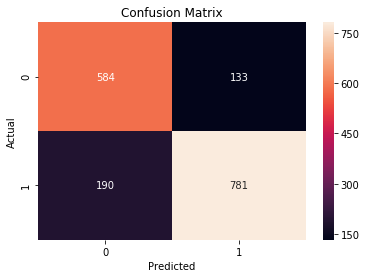

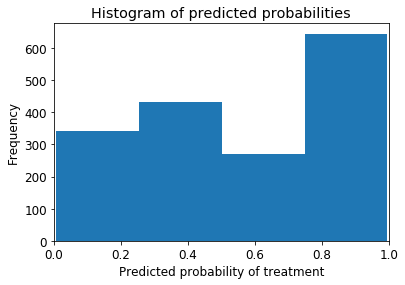

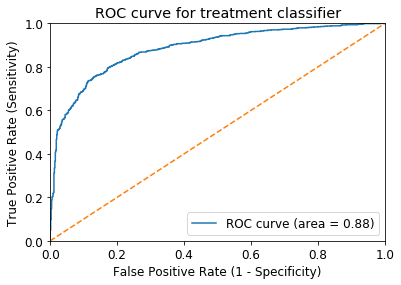

In [7]:
from sklearn.linear_model import LogisticRegression
def logisticRegression():
    modelLogisticRegression = make_pipeline(preprocess, LogisticRegression(solver='liblinear', multi_class='ovr'))
    modelLogisticRegression.fit(X_train, Y_train)

    # make class predictions for the testing set
    y_pred_class = modelLogisticRegression.predict(X_test)

    print('############### Logistic Regression ###############')

    accuracy_score = evaluateModel(modelLogisticRegression, y_pred_class, True)
    
logisticRegression()

## Now it's your turn to implement your own XGBoost Classifier!
Some notes:
- Run `pip install xgboost` to get the xgboost package
- Once you are done training, try evaluating the accuracy of your model using the `evaluateModel` function above and with the test dataset. This model should be more accurate than the Logistic Regression classifier.
- try playing around with tuning the parameters to get the highest accuracy possible!
    - in particular, try tuning the `eta` and `max_depth` parameters!

In [8]:
import xgboost

############################ TODO ############################
# def xgBoost():